In [1]:
# default_exp core
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
from  functools import partial
%matplotlib inline

In [2]:
# to be run if svgwrite is not installed on your system
# !pip install svgwrite

In [3]:
#export
def get_ax(line):
    """ returns the axis of where the move is heading"""
    return 1 if line[0] == line[2] else 0

def line2segmented_pointlist(line, min_tab_mm):
    line=np.array(line)
    ax = get_ax(line)
    ay = (ax+1)%2 
    diff =  line[ax+2] - line[ax]
    if diff<0:
        line = line[[2,3,0,1]]
    num_tabs = int(abs(diff/min_tab_mm))
    if num_tabs%2==0:
        num_tabs -=1
    tab_size= abs(diff/num_tabs)
    all_tabs = np.arange(line[ax], line[ax+2]+1, tab_size)
    ret = np.zeros((len(all_tabs),2))
    ret[:,ax] = all_tabs
    ret[:,ay] = line[ay]
    return ret, ax
        
    

In [4]:
line = [0, 200, 0,0]
segments, ax = line2segmented_pointlist(line, 15)
segments, ax

(array([[  0.        ,   0.        ],
        [  0.        ,  15.38461538],
        [  0.        ,  30.76923077],
        [  0.        ,  46.15384615],
        [  0.        ,  61.53846154],
        [  0.        ,  76.92307692],
        [  0.        ,  92.30769231],
        [  0.        , 107.69230769],
        [  0.        , 123.07692308],
        [  0.        , 138.46153846],
        [  0.        , 153.84615385],
        [  0.        , 169.23076923],
        [  0.        , 184.61538462],
        [  0.        , 200.        ]]),
 1)

In [5]:
#export
def plot_lines(lines):
    for l in lines:
        l = l.reshape(2,2)
        plt.plot(l[:,0], l[:,1])

In [6]:
#export
def segments_to_tabs(segments, ax, tabsize):
    arr_x = np.repeat(segments[:,ax], 2)
    arr_y = np.tile([0,0, tabsize, tabsize], len(segments)//2+1)[1:-3]
    ret = np.zeros((len(arr_x),2))
    ret[:,ax] = arr_x
    ret[:,(ax+1)%2] = arr_y
    points = ret[1:-1,:]
    return np.hstack([points[:-1], points[1:]])
    

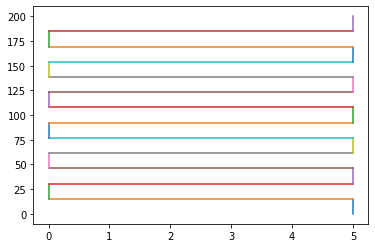

In [7]:
tabs = segments_to_tabs(segments, ax, 5)
plot_lines(tabs)
#tabs

In [8]:
#export
def tabs2holes(tabs, ax):
    tabs=tabs.copy()
    to_modify = np.arange(0,len(tabs)-1,4)
    values_from = np.arange(4,len(tabs),4)
    tabs[to_modify,ax] = tabs[values_from,ax]
    return tabs[:-1]
    

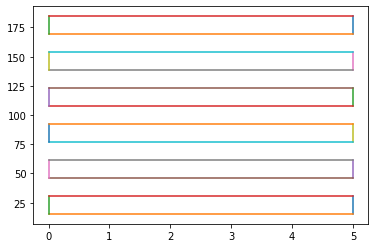

In [9]:
holes =tabs2holes(tabs, ax)
plot_lines(holes)

In [10]:
#export
def generate_tabbed_side(line, min_tab_size, plywood_thick, comp=True):
    segments, ax = line2segmented_pointlist(line, min_tab_size)
    ay = (ax+1)%2
    tabs = segments_to_tabs(segments, ax, plywood_thick)
    tabs[:,ay] += line[ay]
    tabs[:,ay+2] += line[ay]

    tabs[0,ax] += abs(plywood_thick)*comp
    tabs[-1,ax+2] -= abs(plywood_thick)*comp
    return tabs
    

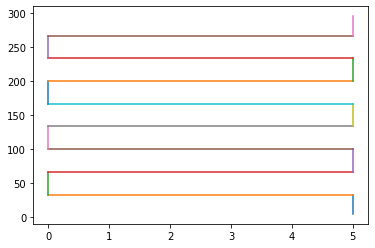

In [11]:
tabs = generate_tabbed_side([0,300,0,0], 30, 5 )
plot_lines(tabs)

In [12]:
#export
def generate_holes_side(line, min_tab_size, plywood_thick):
    segments, ax = line2segmented_pointlist(line, min_tab_size)
    ay = (ax+1)%2
    tabs = segments_to_tabs(segments, ax, plywood_thick)
    tabs[:,ay] += line[ay]
    tabs[:,ay+2] += line[ay]
    tabs[0,ax] += abs(plywood_thick)
    tabs[-1,ax+2] -= abs(plywood_thick)
    return tabs

In [165]:
class Side2:
    def __init__(self, line, height):
        self.x_dir = get_ax(line)
        self.y_dir = (self.x_dir+1)%2
        self.mx, self.my = 0,0
        self.base = np.array(line)

        self.l = np.array([line[0],line[1], line[0],line[1] ])
        self.l[2+self.y_dir] += height
        self.r = np.array([line[2], line[3], line[2], line[3]])
        self.r[2+self.y_dir] += height
        self.t =np.array([self.l[2], self.l[3], self.r[2], self.r[3]])
        self.result = None
        
    def generate_bottomside(self, min_tab_size, thick):
        bottom = generate_tabbed_side(self.base, min_tab_size, thick )
        top = generate_tabbed_side(self.t, min_tab_size, -thick )
        left = generate_tabbed_side(self.l, min_tab_size, thick )
        right = generate_tabbed_side(self.r, min_tab_size, -thick )
        self.result = np.vstack([bottom, top,left,right])
    
    def generate_edge(self, min_tab_size, thick):
        tabs = generate_tabbed_side(self.base, min_tab_size, thick )
        holes = tabs2holes(tabs,self.x_dir)
        holes[:,[self.y_dir, self.y_dir+2]] += thick
        
        d = 1 if self.x_dir==0 else -1
        left = generate_tabbed_side(self.l, min_tab_size, d*thick,comp=False )
        right = generate_tabbed_side(self.r, min_tab_size, -d*thick,comp=False )
        top = self.t.copy()
        base = self.base.copy()
        if self.x_dir:
            right[:, [self.x_dir, self.x_dir+2] ] -=thick
            left[:, [self.x_dir, self.x_dir+2] ] +=thick
        else:
            top += [thick, 0, -thick,0]
            base +=[thick, 0, -thick,0]
        self.result = np.vstack([holes, left, right, top, base])
        
    def add_holes(self, line, min_tab_size, thick):
        line = np.array(line)
        ax = get_ax(line)
        line += [self.mx, self.my, self.mx, self.my]
        assert len(line)==4
        tabs = generate_tabbed_side(line, min_tab_size, thick )
        holes = tabs2holes(tabs,ax)
        self.result = np.vstack([self.result, holes])
        
    def generate_inner_wall(self, min_tab_size, thick):
        tabs1 = generate_tabbed_side(self.base, min_tab_size, thick, comp=True )
        tabs1[:,[self.y_dir,self.y_dir+2]] -= thick
        tabs2 = generate_tabbed_side(self.l, min_tab_size, thick,comp=False)
        
        tabs3 = generate_tabbed_side(self.r, min_tab_size, -thick, comp=False)
        top = self.t.copy()
        top[self.x_dir] +=thick
        top[self.x_dir+2] -=thick
            
        self.result = np.vstack([tabs1, tabs2, tabs3,top ])
        self.move(0, thick)
        self.mx, self.my =0, 0
        
    def flip_h(self):
        self.result[:,[0,2]] = -self.result[:,[0,2]] + np.max(self.result[:,[0,2]])
        
    def flip_v(self):
        self.result[:,[1,3]] = -self.result[:,[1,3]] + np.max(self.result[:,[1,3]])
        
    def move(self, x, y):
        self.mx +=x
        self.my +=y
        self.result += [x,y,x,y]
        
    def plot(self):
        plot_lines(self.result)
        #plot_lines([self.base, self.l, self.r, self.t])

# Holes example

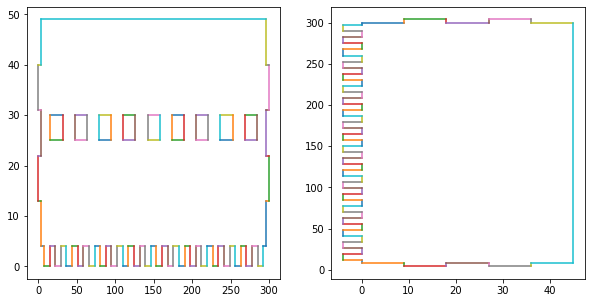

In [166]:

l = [0,0, 300, 0]

s = Side2(l, 45 )
s.generate_inner_wall(7,4)
s.add_holes(line, min_tab_size=15, thick=5)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
s.plot()

l = [0,0, 0, 300]
s = Side2(l, 45 )
s.generate_inner_wall(7,4)
plt.subplot(1,2,2)
s.plot()

# Walls example

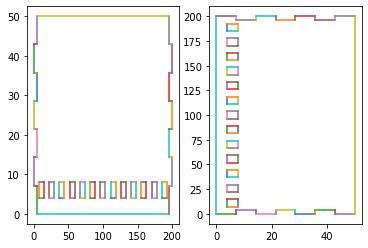

In [145]:
l = [0, 0, 200, 0]
s = Side2(l, 50)
s.generate_edge(7, 4)
plt.subplot(1,2,1)
s.plot()

l = [0, 0, 0, 200]
s = Side2(l, 50)
s.generate_edge(7, 4)
plt.subplot(1,2,2)
s.plot()


# Bottom Side example

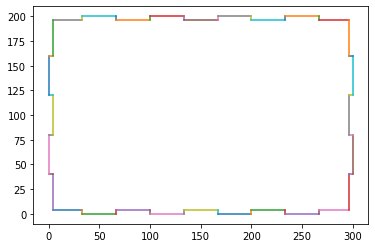

In [86]:
l = [0,0,300,0]
s = Side2(l, 200)
s.generate_bottomside(30, 4)
s.plot()

In [205]:
def line_intersection(line1, line2):
    line1 = np.array(line1)
    line2 = np.array(line2)
    #xdiff = line1[0] - line1[2], line2[0] - line2[2]
    #ydiff = line1[1]- line1[3], line2[1]- line2[3]
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    print(div)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    
    v1 = [x,y]-line1[0]
    length = np.sqrt(v1[0]**2 + v1[1]**2)
    line1_length = np.sqrt(xdiff[0]**2 + ydiff[0]**2)
    print(length)
    print(line1_length)
    return x, y

In [206]:
line1 = [[0,0], [10,10]]
line2 = [[7,0], [0, 7]]

print(line_intersection(line1, line2))

140
4.949747468305833
14.142135623730951
(3.5, 3.5)


In [186]:
7*5*2

70

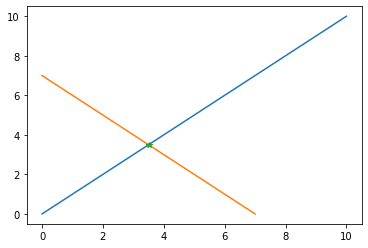

In [188]:
plot_lines(np.array([[0,0,10,10],[7,0,0,7]]))
plt.plot([3.5],[3.5], '*')

In [127]:
#export
class Side:
    def __init__(self, name, p0, p1, p2, p3, ax):
        """ p0-p3 is the points of the box in clock-wise order"""
        self.name=name
        self.ax = ax
        self.left = np.array(p0 + p1)
        self.top = np.array(p1 + p2)
        self.right = np.array(p2 + p3)
        self.bottom = np.array(p3 + p0)
        self.resut = None
        self.mx=0
        self.my=0
        
    def generate_bottomside(self, min_tab_size, thick): 
        bottom =generate_tabbed_side(self.bottom, min_tab_size, thick )
        top = generate_tabbed_side(self.top, min_tab_size, -thick )
        left = generate_tabbed_side(self.left, min_tab_size, thick )
        right = generate_tabbed_side(self.right, min_tab_size, -thick )
        self.result = np.vstack([bottom, top,left,right])
        

        
    
    def generate_ul_side(self, min_tab_size, thick):
        tabs = generate_tabbed_side(self.bottom, min_tab_size, thick )
        holes = tabs2holes(tabs,0)
        holes += [0, thick, 0, thick]  
        left = generate_tabbed_side(self.left, min_tab_size, -thick,comp=False )
        left += [thick,0, thick,0]
        right = generate_tabbed_side(self.right, min_tab_size, thick,comp=False )
        right -= [thick,0, thick,0]
        self.result = np.vstack([holes, left, right, self.top, self.bottom])

    def generate_lr_side(self,min_tab_size, thick):
        tabs = generate_tabbed_side(self.left, min_tab_size, thick )
        holes = tabs2holes(tabs,1)
        holes += [thick, 0, thick, 0] 
        
        top = generate_tabbed_side(self.top, min_tab_size, -thick,comp=False )   
        bottom = generate_tabbed_side(self.bottom, min_tab_size, thick,comp=False ) 
        left = self.left.copy()
        left += [0, thick,0, -thick]
        right = self.right.copy()
        right += [0, -thick,0, thick]
        self.result = np.vstack([holes, top, bottom, left, right])
        
    def add_holes(self, line, min_tab_size, thick):
        line = np.array(line)
        ax = get_ax(line)
        line += [self.mx, self.my, self.mx, self.my]
        assert len(line)==4
        tabs = generate_tabbed_side(line, min_tab_size, thick )
        holes = tabs2holes(tabs,ax)
        self.result = np.vstack([self.result, holes])
        
        
    def generate_inner_wall(self, min_tab_size, thick):
        tabs1 = generate_tabbed_side(self.bottom, min_tab_size, thick, comp=True )
        tabs1 += [0, -thick, 0, -thick]
        tabs2 = generate_tabbed_side(self.left, min_tab_size, thick,comp=False)
        
        tabs3 = generate_tabbed_side(self.right, min_tab_size, -thick, comp=False)
        top = self.top.copy()
        top +=[thick,0,-thick,0]
            
        self.result = np.vstack([tabs1, tabs2, tabs3,top ])
        self.move(0, thick)
        self.mx, self.my =0, 0
        
    def flip_h(self):
        self.result[:,[0,2]] = -self.result[:,[0,2]] + np.max(self.result[:,[0,2]])
        
    def flip_v(self):
        self.result[:,[1,3]] = -self.result[:,[1,3]] + np.max(self.result[:,[1,3]])
        
    def move(self, x, y):
        self.mx +=x
        self.my +=y
        self.result += [x,y,x,y]
        
    def plot(self):
        plot_lines(self.result)


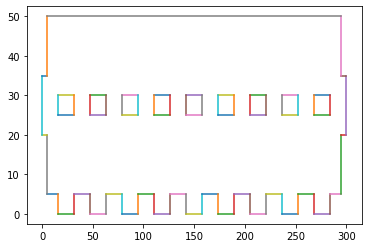

In [14]:
x=300
y=50-5
s = Side('inner', 
        p0= [0,0],
        p1 = [0,y],
        p2 = [x,y],
        p3 = [x,0],
        ax=ax)
s.generate_inner_wall(min_tab_size=15, thick=5)
line = np.array([0,25,300,25])
s.add_holes(line, min_tab_size=15, thick=5)
s.plot()

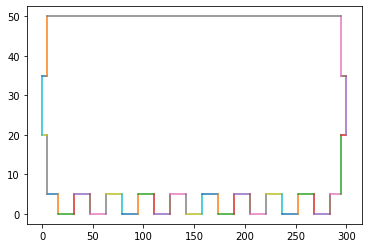

In [481]:
x=300
y=50-5
s = Side('inner', 
        p0= [0,0],
        p1 = [0,y],
        p2 = [x,y],
        p3 = [x,0])
s.generate_inner_wall(min_tab_size=15, thick=5)
s.plot()

[300   0   0   0] 30 5


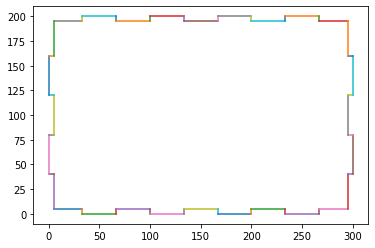

In [207]:
x=300
y=200
s = Side('bottom', 
        p0= [0,0],
        p1 = [0,y],
        p2 = [x,y],
        p3 = [x,0])
s.generate_bottomside(min_tab_size=30, thick=5)
s.plot()

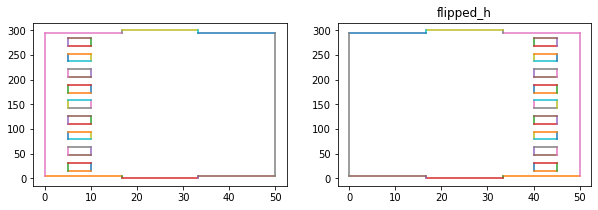

In [549]:
x=50
y=300
s = Side('left', 
        p0= [0,0],
        p1 = [0,y],
        p2 = [x,y],
        p3 = [x,0])
s.generate_lr_side(min_tab_size=15, thick=5)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
s.plot()

plt.subplot(1,2,2)
plt.title('flipped_h')
s.flip_h()
s.plot()

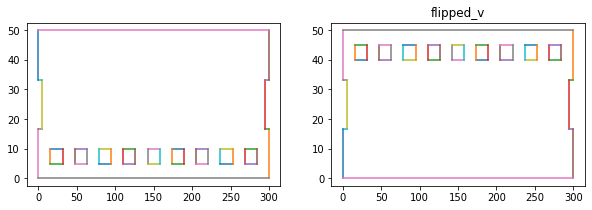

In [550]:
x=300
y=50
s = Side('lower', 
        p0= [0,0],
        p1 = [0,y],
        p2 = [x,y],
        p3 = [x,0])

s.generate_ul_side(min_tab_size=15, thick=5)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
s.plot()
plt.subplot(1,2,2)
plt.title('flipped_v')
s.flip_v()
s.plot()

In [551]:
def gen_points(x, y):
    return [0,0], [0, y], [x, y ], [x, 0]

In [552]:
s = Side('bottom', *gen_points(200,300))

In [553]:
class BoxInfo:
    def __init__(self, 
                 playwood_thickness,
                x_size_mm, y_size_mm,
                height_mm,
                min_tabsize_mm=30):
        self.thickness = playwood_thickness
        self.x = x_size_mm
        self.y = y_size_mm
        self.height = height_mm
        self.min_tabsize = min_tabsize_mm
        self.inner_walls_lines = list()
        self.isides = list()
        


        self.bottom = Side('bottom', *gen_points(x_size_mm, y_size_mm))
        self.bottom.generate_bottomside(min_tabsize_mm, playwood_thickness)
        
        
        self.left = Side('left',*gen_points(height_mm, y_size_mm))
        self.left.generate_lr_side(min_tabsize_mm, playwood_thickness)
        self.left.flip_h()
        self.left.move(-height_mm, 0)
        
        self.right = Side('right',*gen_points(height_mm, y_size_mm))
        self.right.generate_lr_side(min_tabsize_mm, playwood_thickness)
        self.right.move(x_size_mm, 0)
        
        self.upper = Side('upper',*gen_points(x_size_mm, height_mm))
        self.upper.generate_ul_side(min_tabsize_mm, playwood_thickness)
        self.upper.move(0, y_size_mm)
        
        self.lower = Side('lower',*gen_points(x_size_mm, height_mm))
        self.lower.generate_ul_side(min_tabsize_mm, playwood_thickness)
        self.lower.flip_v()
        self.lower.move(0, -height_mm)
    
    def plot_outline(self):
        p1,p2,p3,p4 =gen_points(self.x, self.y)
        lines = np.array([p1 + p2, p2+p3, p3+p4, p4+p1])
        plot_lines(lines)
        plot_lines(self.inner_walls_lines)
        
    def add_innerwall(self, p1,p2):
        line = np.array(p1+p2)
        self.inner_walls_lines.append(line)
        
        ax = get_ax(line)
        width = abs(line[ax] - line[ax+2])
        h = self.height-self.thickness
        #(x,y) = (width, h) if ax==0 else (h, width)
        s = Side('left',*gen_points(width, h))
        s.generate_inner_wall(self.min_tabsize, self.thickness)
        s.move(0, self.thickness)
        self.isides.append(s)
        self.bottom.add_holes(line, self.min_tabsize, self.thickness)
        if ax==0:
            l1 = [self.thickness*2, line[1], self.height, line[1]]
            self.right.add_holes(l1, self.min_tabsize, self.thickness )
            l2 = [0, line[1], self.height-self.thickness*2, line[1]]
            self.left.add_holes(l2, self.min_tabsize, self.thickness )
        else:
            l1 = [line[0], self.thickness, line[0], self.height]
            self.upper.add_holes(l1, self.min_tabsize, self.thickness )
            l2 = [line[0], 0, line[0], self.height - self.thickness*2]
            self.lower.add_holes(l2, self.min_tabsize, self.thickness )
            
        # todo, addera slits för skärande innerväggar.
        
        
        
    def plot(self):
        self.bottom.plot()
        self.left.plot()
        self.right.plot()
        self.upper.plot()
        self.lower.plot()
        move_y = -self.height*2-self.thickness
        for s in self.isides:
            s.move(0, move_y)  # move just to prevent plots from laying on top of eachother
            s.plot()
            s.move(0, -move_y)
            move_y-=self.height
    
    @staticmethod
    def to_dwg(obj, dwg):
        for r in obj.result:
            dwg.add(dwg.line((r[0],r[1]),(r[2],r[3]), stroke="#000"))
        
    def export_to_svg(self, filename):
        dwg = svgwrite.Drawing(filename, profile='tiny')
        func1 = partial(self.to_dwg, dwg=dwg)
        list(map(func1, [self.bottom, self.left, self.right, self.upper, self.lower]))
        dwg.save()
                               
    

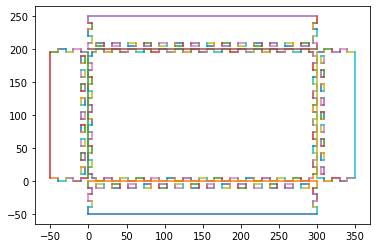

In [554]:
box = BoxInfo(playwood_thickness=5,
                x_size_mm=300, y_size_mm=200,
                height_mm=50,
                min_tabsize_mm=10)
box.plot()

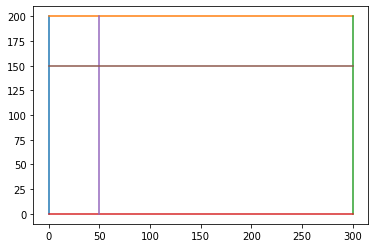

In [555]:
box.add_innerwall((50,0), (50,200))
box.add_innerwall((0,150), (300,150))
box.plot_outline()

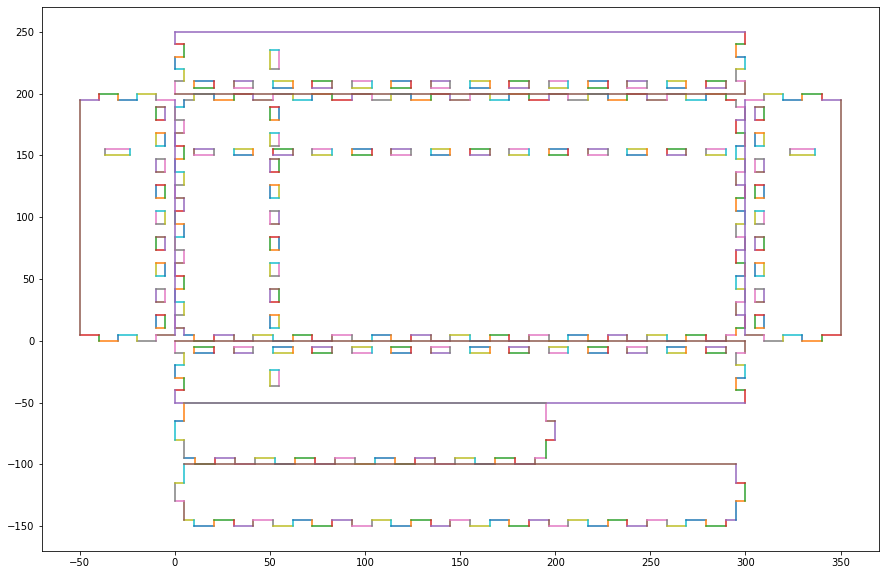

In [541]:
plt.figure(figsize=(15,10))
box.plot()

In [ ]:
# todo, find intersecting midwalls.

In [ ]:
1. skapa en SVG fil av hela skiten.
2. få till att man kan skapa avdelningar i lådan.
